In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
from time import time

In [3]:
from citrination_client import CitrinationClient
from xrsdkit.tools.citrination_tools import get_data_from_Citrination

In [4]:
from xrsdkit.models.training import train_classifiers, train_regressors, save_models

In [5]:
from sklearn import preprocessing,linear_model
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

saxskit uses SAXS spectra to identify scatterer populations (via several classification models) and predict the associated scattering parameters (via regression models). The saxskit API allows the user to choose between models based on scikit-learn or models based on Citrination (not updated yet). 

saxskit includes models for:
* two binary classifiers:
    * 'crystalline': True if there is at least one crystalline population
    * 'diffuse': True is there is at least one diffuse population
If a sample has no crystalline and no diffuse populations, if is labeled 'unidentified' (scatterers cannot be identified easily from the data).
* two multi class classifiers (not implemented yet):
    * 'spherical_normal': 0/1/2... the class name corresponds to the number of normal distributions of spherical scatterers.
    * 'guinier_porod': 0/1/2... the class name corresponds to the number of scatterers described by a Guinier-Porod equation

## Training saxskit models for Crystalline and Diffuse populations

In [6]:
p = os.getcwd()
d, _  = os.path.split(p)
classifiers_path = os.path.join(d,'xrsdkit','models','modeling_data','scalers_and_models.yml')
regressors_path = os.path.join(d,'xrsdkit','models','modeling_data','scalers_and_models_regression.yml')

#### Get data from Citrination using Citrination credentials

In [7]:
api_key_file = os.path.join(d, 'api_key.txt')
if not os.path.exists(api_key_file):
    print("Citrination api key file did not find")

In [8]:
with open(api_key_file, "r") as g:
    a_key = g.readline().strip()
cl = CitrinationClient(site='https://slac.citrination.com',api_key=a_key)

data = get_data_from_Citrination(client = cl, dataset_id_list= [21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]) 

In [9]:
data.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,pearson_invexpq,I0_over_Imean,I0_curvature,q_at_half_I0,q_at_Iq4_min1,pIq4_qwidth,pI_qvertex,pI_qwidth,crystalline_structure_flag,diffuse_structure_flag
1817,Reaction_E,7.93327,1.00977,0.00142163,3.37159,2.58633,0.100574,0.00238663,0.089622,0.0955949,...,0.728886,1422.7,-0.00644035,0.134448,0.233039,0.0136052,0.238792,0.0205062,0,1
203,R1,17.0907,1.02997,0.00160169,16.6637,2.89492,0.107235,0.00185529,0.067786,-0.370521,...,0.553848,694.437,0.218201,0.0972913,0.132576,0.00710138,0.134675,0.00917924,1,0
555,R3,33.4061,1.63435,0.00231671,112.244,3.41958,0.0647679,0.00185529,0.0673906,0.0683232,...,0.426138,2309.27,0.398188,0.0764803,0.0802128,0.00639489,0.08275,0.00676133,1,0
227,R1,18.7938,1.03306,0.00110202,3.956,2.93016,0.107776,0.00185529,0.0649982,-0.591069,...,0.528142,712.02,0.253135,0.0952102,0.132853,0.00700776,0.134993,0.00741972,0,1
1429,R13,17.5248,1.02678,0.00103468,4.00336,3.07291,0.104028,0.00171821,0.0675562,-0.269541,...,0.537174,570.784,0.243507,0.096644,0.136314,0.00751907,0.13948,0.00898696,0,1


At this point, **data** is a pandas data frame that contains (for each SAXS record):

* experiment_id - The experiment ID is used for cross-validation grouping. Often, samples from the same experiment are very similar, so cross-validating in this way avoids overtraining.

* An array of numerical features that describe the shape of the spectrum (invariant with respect to intensity scaling).
 
* Two True / False labels (for classification models): 
    - 'diffuse'
    - 'crystalline'

#### Train Classifiers and Save The Models

For training from scratch, we use train_classifiers() with hyper_parameters_search = True. This will seek a set of model hyperparameters that optimizes the model.
The final set of hyperparameters is the set that provides the highest mean accuracy on the given test data and labels. 

Since samples from the same experiment are often highly correlated, saxskit uses a "Leave-N-Groups-Out" technique to evaluate training error. Saxskit leaves two groups (experiment_ids) out for each training cycle. For example, if we have experiments 1 through 5:
* train the model on 1, 2, and 3; test on 4 and 5
* train the model on 1, 2, and 4; test on 3 and 5
* ...
* (etc: perform all possible training/testing combinations)
* ...
* calculate average accuracy

In [10]:
t0 = time()
scalers, models, accuracy = train_classifiers(data, hyper_parameters_search = True, model='all')
print("Training took about {:.2f} minutes".format((time()-t0)/60))

save_models(scalers, models, accuracy, classifiers_path)

Training took about 3.11 minutes


A set of serialized scalers and models will be saved in the package's source directory at:

**xrsdkit/models/modeling_data/scalers_and_models.yml**

The accuracy of the trained models will also be reported in:

**xrsdkit/models/modeling_data/scalers_and_models.txt**

To calculate the reported accuracy "Leave-N-Groups-Out" technique is also used. Every cycle data from two experiments used for testing and the other data for training. The average accuracy is reported. 

train_classifiers() has an optional argument 'model' which can be used to specify the model to train. For example:

    scalers, models, accuracy = train_classifiers(data, hyper_parameters_search = True, model='diffuse')
    
The names of models to train :"diffuse", "crystalline".

In [11]:
print('-----trained model accuracies-----')
for model_name, acc in accuracy.items():
    print('{}: {:.4f}'.format(model_name,acc))

-----trained model accuracies-----
diffuse: 0.9552
crystalline: 0.9813


In [ ]:
branches = ['bad_data', 'form', 'precursor', 'structure']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
st = fig.suptitle("All Data", fontsize=20)
for n in range(2): # max number of classes is 9, but we have only 6 now
    br = branches[n]
    sns.countplot(x=br, data=df_work, palette='rainbow', ax=axes[n])
    #axes[n].set_title("Label: " + br, fontsize=20);
axes[0].set_ylabel('Count', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[0].set_xlabel('Bad Data',fontsize=18)
axes[1].set_xlabel("Form Factor Scattering", fontsize=18);

## Error analysis for Crystalline and Diffuse populations models.

Now I am going to use about the same technic: train the models on all data excluding one experiment and then test on the data from excluded experiment.

In [12]:
experiments = data.experiment_id.unique()
experiments

array(['Reaction_E', 'R1', 'R3', 'R13', 'R6', 'Reaction_C', 'R12',
       'Reaction_H', 'Reaction_A', 'Reaction_B', 'R4', 'R5', 'R7',
       'Reaction_D', 'R2', 'Reaction_G'], dtype=object)

In [13]:
from xrsdkit.tools.profiler import profile_keys_1
features = profile_keys_1

In [17]:
def set_param(m_s, param):
    for k, v in param.items():
        if isinstance(v, list):
            setattr(m_s, k, np.array(v))
        else:
            setattr(m_s, k, v)

In [22]:
test_results = [] # dataframes
diffuse_scores = []
crystalline_scores = []

for d in experiments:
    train = data[data['experiment_id']!= d]
    test = data[data['experiment_id']== d]
    scalers, models, accuracy = train_classifiers(train, hyper_parameters_search = True, model='all')
    
    s1 = preprocessing.StandardScaler()
    set_param(s1,scalers['diffuse'])
    transf1 = s1.transform(test[features])
    m1 = linear_model.SGDClassifier()
    set_param(m1,models['diffuse'])
    test.diffuse_predicted = m1.predict(transf1)
    test_score_diffuse = m1.score(transf1, test['diffuse'])
    diffuse_scores.append(test_score_diffuse)
    
    s2 = preprocessing.StandardScaler()
    set_param(s2,scalers['crystalline'])
    transf2 = s2.transform(test[features])
    m2 = linear_model.SGDClassifier()
    set_param(m2,models['crystalline'])
    test.crystalline_predicted = m2.predict(transf2)
    test_score_crystalline = m2.score(transf2, test['crystalline'])
    crystalline_scores.append(test_score_crystalline)
    
    test_results.append(test)

Text(0,0.9,'Number of outcomes')

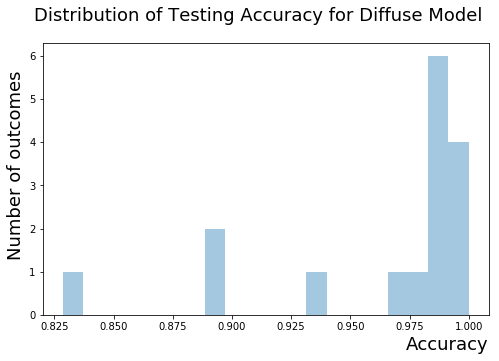

In [25]:
plt.figure(figsize=(8,5))
sns.distplot(diffuse_scores, kde=False, bins=20)
plt.suptitle("Distribution of Testing Accuracy for Diffuse Model", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

Text(0,0.9,'Number of outcomes')

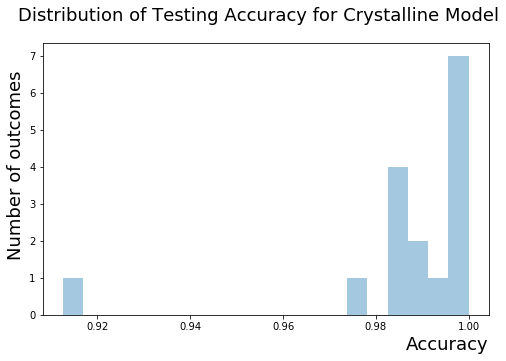

In [26]:
plt.figure(figsize=(8,5))
sns.distplot(crystalline_scores, kde=False, bins=20)
plt.suptitle("Distribution of Testing Accuracy for Crystalline Model", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [ ]:
cnf_matrix = confusion_matrix(test_results[0]['diffuse'], test_good['form_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")




## Crystalline Model

In [14]:
parameters = {'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1], #regularisation coef, default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.85, 1.0]} #using with elasticnet only; default 0.15

In [18]:
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GridSearchCV

cv=LeavePGroupsOut(n_groups=2).split(data[features], data[['crystalline_structure_flag']], groups=data['experiment_id'])

scaler = preprocessing.StandardScaler()
scaler.fit(data[features])
svc = linear_model.SGDClassifier(loss = 'log')
clf = GridSearchCV(svc, parameters, cv=cv)
    
clf.fit(scaler.transform(data[features]), data['crystalline_structure_flag'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'l1_ratio': 0.15, 'penalty': 'none'}
Training score:  0.985


In [32]:
test_scores_by_ex = []
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        tr = data[(data['experiment_id']!= experiments[i]) & (data['experiment_id']!= experiments[j])]
        test = data[(data['experiment_id']== experiments[i]) | (data['experiment_id']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.0001,loss= 'log', l1_ratio = 0.15, penalty= 'none')

        log.fit(scaler.transform(tr[features]), tr['crystalline_structure_flag'])
        test_score = log.score(scaler.transform(test[features]), test['crystalline_structure_flag'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        count +=1
        
print("Average testing score: ", sum(test_scores_by_ex)/count)
print(count)

test score:  0.99433427762
test score:  0.99512195122
test score:  0.981595092025
test score:  0.994011976048
test score:  0.709459459459
test score:  0.98087431694
test score:  0.80487804878
test score:  0.992647058824
test score:  0.992
test score:  0.989304812834
test score:  0.954732510288
test score:  0.993288590604
test score:  0.992307692308
test score:  0.994444444444
test score:  1.0
test score:  0.979452054795
test score:  0.982323232323
test score:  0.9825
test score:  0.98687664042
test score:  0.974958263773
test score:  0.98595505618
test score:  0.991869918699
test score:  0.983240223464
test score:  0.983333333333
test score:  0.943277310924
test score:  0.986910994764
test score:  0.98347107438
test score:  0.978208232446
test score:  0.988372093023
test score:  0.995967741935
test score:  0.988095238095
test score:  0.995708154506
test score:  0.982261640798
test score:  0.995192307692
test score:  0.990950226244
test score:  0.990476190476
test score:  0.985294117647

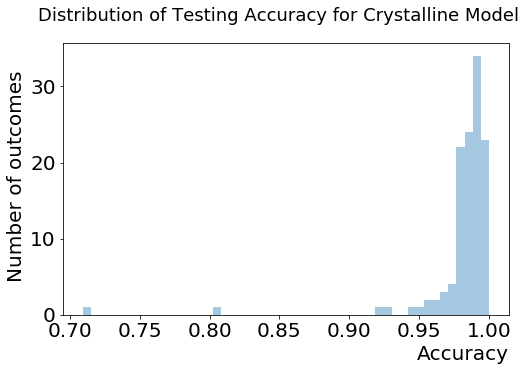

In [33]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for Crystalline Model", fontsize=18)
plt.xlabel('Accuracy', fontsize=20,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=20, horizontalalignment='right', y=0.9)
plt.tick_params(labelsize=20)

In [23]:
min(test_scores_by_ex)

0.58115183246073299

In [24]:
max(test_scores_by_ex)

1.0

## Diffuse Model

In [25]:
cv=LeavePGroupsOut(n_groups=2).split(data[features], data[['diffuse_structure_flag']], groups=data['experiment_id'])

scaler = preprocessing.StandardScaler()
scaler.fit(data[features])
svc = linear_model.SGDClassifier(loss = 'log')
clf = GridSearchCV(svc, parameters, cv=cv)
    
clf.fit(scaler.transform(data[features]), data['diffuse_structure_flag'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'l1_ratio': 0.5, 'penalty': 'none'}
Training score:  0.957


In [26]:
test_scores_by_ex = []
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        tr = data[(data['experiment_id']!= experiments[i]) & (data['experiment_id']!= experiments[j])]
        test = data[(data['experiment_id']== experiments[i]) | (data['experiment_id']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.0001,loss= 'log', l1_ratio = 0.5, penalty= 'none')

        log.fit(scaler.transform(tr[features]), tr['diffuse_structure_flag'])
        test_score = log.score(scaler.transform(test[features]), test['diffuse_structure_flag'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        count +=1
        
print("Average testing score: ", sum(test_scores_by_ex)/count)
print(count)

test score:  0.960339943343
test score:  0.960975609756
test score:  0.981595092025
test score:  0.988023952096
test score:  1.0
test score:  0.975409836066
test score:  1.0
test score:  0.992647058824
test score:  0.992
test score:  0.994652406417
test score:  0.934156378601
test score:  0.986577181208
test score:  0.961538461538
test score:  0.983333333333
test score:  1.0
test score:  0.929223744292
test score:  0.926767676768
test score:  0.925
test score:  0.939632545932
test score:  0.931552587646
test score:  0.941011235955
test score:  0.934959349593
test score:  0.935754189944
test score:  0.933333333333
test score:  0.930672268908
test score:  0.934554973822
test score:  0.933884297521
test score:  0.9200968523
test score:  0.915697674419
test score:  0.95564516129
test score:  0.984126984127
test score:  0.987124463519
test score:  0.975609756098
test score:  0.899038461538
test score:  0.995475113122
test score:  0.933333333333
test score:  0.988970588235
test score:  0.990

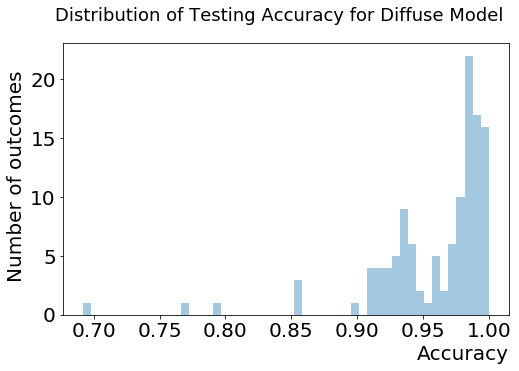

In [31]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for Diffuse Model", fontsize=18)
plt.xlabel('Accuracy', fontsize=20,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=20, horizontalalignment='right', y=0.9)
plt.tick_params(labelsize=20)

In [28]:
min(test_scores_by_ex)

0.69193154034229831

In [29]:
max(test_scores_by_ex)

1.0

#### Step 3. Train and Save Regression models

The approach is the same as above, but for a different set of models. These are the three regression models for the scattering spectrum parameters affecting curve shape. In the current version, the regression model output is one-dimensional, so these are mostly useful for spectra containing **one** 'guinier_porod' and/or **one** 'spherical_normal' scatterer population.

In [9]:
t0 = time()
scalers, models, accuracy = train_regressors(data, hyper_parameters_search = True, model= 'all')
print("Training took about {:.2f} minutes".format((time()-t0)/60))

save_models(scalers, models, accuracy, regressors_path)

Training took about 15.67 minutes


A set of serialized scalers and models will be saved in the package's source directory at:

**saxskit/modeling_data/scalers_and_models_regression.yml**

Note, for the regression models, the "Leave-N-Groups-Out" cross validation is used, also with N=2. The reported error for each model is the mean absolute validation error divided by the standard deviation of the training data. The accuracy of the trained models will also be reported in:

**saxskit/modeling_data/scalers_and_models_regression.txt**

train_regressors() has an optional argument 'model' which can be used to specify the model to train. For example:

    scalers, models, accuracy = train_regressors(data, hyper_parameters_search = False, model= 'r0_sphere')
    
The names of models to train :"r0_sphere", "sigma_sphere", "rg_gp", or "all" to train all models.

In [10]:
print('-----trained model accuracies-----')
for model_name, acc in accuracy.items():
    print('{}: {:.4f}'.format(model_name,acc))

-----trained model accuracies-----
r0_sphere: 0.2921
sigma_sphere: 0.6119
rg_gp: 0.2768
